In [17]:
!pip3 install matplotlib

import torch
import pandas as pd
from matplotlib import pyplot
path = "https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations/USW00014837.csv.gz"
df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])

#https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations/USW00014839.csv.gz


Defaulting to user installation because normal site-packages is not writeable


/tmp/ipykernel_60934/2727945046.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])


In [18]:
##df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", names=["x0", "x1", "x2", "x3", "variety"])
##df.head()


In [20]:
df["element"].isin(["TMIN", "TMAX"])

0          True
1          True
2          True
3          True
4          True
          ...  
409846    False
409847    False
409848    False
409849    False
409850    False
Name: element, Length: 409851, dtype: bool

In [21]:
df2 = df[df["element"].isin(["TMIN", "TMAX"])]
df2

station      date element  value    m    q  s     obs
0       USW00014837  19391001    TMAX    194  NaN  NaN  X     NaN
1       USW00014837  19391002    TMAX    211  NaN  NaN  X     NaN
2       USW00014837  19391003    TMAX    233  NaN  NaN  X     NaN
3       USW00014837  19391004    TMAX    272  NaN  NaN  X     NaN
4       USW00014837  19391005    TMAX    211  NaN  NaN  X     NaN
...             ...       ...     ...    ...  ...  ... ..     ...
409648  USW00014837  20230116    TMIN     22  NaN  NaN  D  2400.0
409649  USW00014837  20230117    TMIN     17  NaN  NaN  W  2400.0
409650  USW00014837  20230118    TMIN      0  NaN  NaN  W  2400.0
409651  USW00014837  20230119    TMIN      0  NaN  NaN  W  2400.0
409652  USW00014837  20230120    TMIN    -32  NaN  NaN  W  2400.0

[60856 rows x 8 columns]

<AxesSubplot: xlabel='TMIN', ylabel='TMAX'>

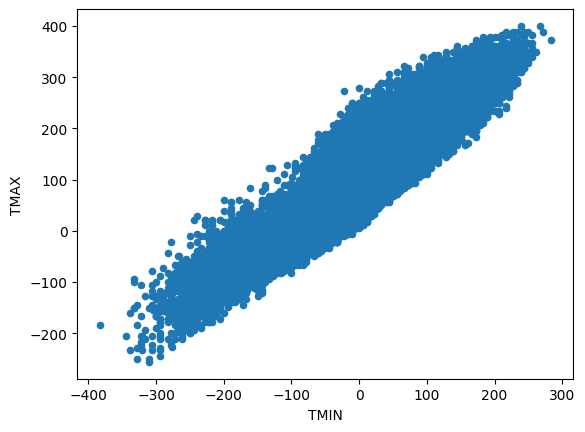

In [22]:
# GOAL: predict tmax given tmin

temps = df2.pivot(index = "date", columns = "element", values = "value")
temps

temps.plot.scatter(x = "TMIN", y = "TMAX")

In [23]:
# Pytorch Data:
# 1. Dataset
# 2. DataLoader: use Dataset and provides shuffling and batching

torch.tensor(temps[["TMAX"]].values, dtype = torch.float32)

tensor([[194.],
        [211.],
        [233.],
        ...,
        [ 28.],
        [ 22.],
        [  0.]])

In [24]:
ds = torch.utils.data.TensorDataset(
    torch.tensor(temps[["TMIN"]].values, dtype = torch.float32),
    torch.tensor(temps[["TMAX"]].values, dtype = torch.float32)
)

ds[1]
    

(tensor([33.]), tensor([211.]))

In [25]:
class TempDS(torch.utils.data.dataset.Dataset):
    def __init__(self, path):
        df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])
        df2 = df[df["element"].isin(["TMIN", "TMAX"])]
        temps = df2.pivot(index = "date", columns = "element", values = "value")
        self.X = torch.tensor(temps[["TMIN"]].values, dtype = torch.float32)
        self.Y = torch.tensor(temps[["TMAX"]].values, dtype = torch.float32)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)
    
df = TempDS(path)

len(df)

/tmp/ipykernel_60934/1941232278.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, names=["station", "date", "element", "value", "m", "q", "s", "obs"])


30428

In [29]:
model = torch.nn.Linear(1, 1)


dl = torch.utils.data.DataLoader(ds, shuffle = True, batch_size = 10)
optimizer = torch.optim.SGD([model.weight, model.bias], lr = .00001)
loss_fn = torch.nn.MSELoss()

for x, y in dl:
    print(x)
    print(y)
    break

for epoch in range(50):
    for batchx, batchy in dl:
        predictedy = model(batchx)
        loss = loss_fn(batchy, predictedy)
        loss.backward() # upddates weight.grad and loss.grad
        optimizer.step()
        optimizer.zero_grad() # weight.grad = 0 and bias.grad = 0
    
    x, y = ds[:]
    print(epoch, loss_fn(y, model(x)))

tensor([[  89.],
        [-167.],
        [  56.],
        [ 117.],
        [  94.],
        [-194.],
        [ 189.],
        [ -61.],
        [ -94.],
        [ -50.]])
tensor([[283.],
        [-39.],
        [133.],
        [300.],
        [183.],
        [-94.],
        [311.],
        [ 33.],
        [-33.],
        [ 72.]])
0 tensor(13120.4102, grad_fn=<MseLossBackward0>)
1 tensor(11319.5996, grad_fn=<MseLossBackward0>)
2 tensor(10314.5732, grad_fn=<MseLossBackward0>)
3 tensor(9520.1143, grad_fn=<MseLossBackward0>)
4 tensor(8833.1816, grad_fn=<MseLossBackward0>)
5 tensor(8043.5356, grad_fn=<MseLossBackward0>)
6 tensor(7363.4404, grad_fn=<MseLossBackward0>)
7 tensor(6783.1387, grad_fn=<MseLossBackward0>)
8 tensor(6170.1968, grad_fn=<MseLossBackward0>)
9 tensor(5770.0854, grad_fn=<MseLossBackward0>)
10 tensor(5314.3125, grad_fn=<MseLossBackward0>)
11 tensor(5079.6768, grad_fn=<MseLossBackward0>)
12 tensor(4738.7388, grad_fn=<MseLossBackward0>)
13 tensor(4411.3179, grad_fn=<MseLossB